In [ ]:
#testing MCMC with the a model function Mira

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee

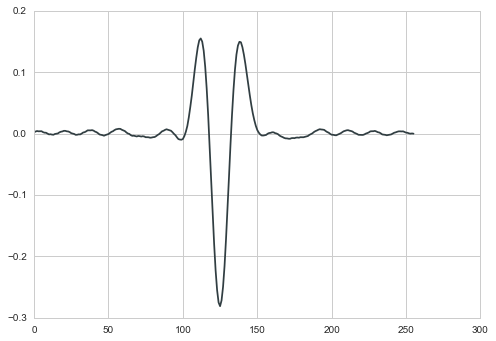

In [2]:
file=open( '../../data/raw_data/20160707_1940_x_mirror_1in_aperture.pkl' , 'rb')
d=pickle.load(file)
file.close()

i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(D)

In [3]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = 256
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

In [4]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    znot, q, p, T, a = params 
    t,Modelf = psi1(znot,q,p, T)
    Dev = -.5*(np.dot((D-Modelf*a),D-Modelf*a))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

In [5]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [-.02, 8.57, .05, .02, .0002], args=(t,D))
znot1,q1,p1,T1,a1 = result["x"]
print result ["x"]

[ -2.00000000e-02   8.57000000e+00   5.00000000e-02   2.00000000e-02
   2.00000000e-04]


In [6]:
#prior function
#again, why is it ln?
def lnprior(params):
    znot, q, p, T, a = params 
    if -.08 < znot < .08 and 1.0 < q < 15.0 and .01 < p < .1 and 0.0 < T < .06 and 0.0 < a < .0005:
        return 0.0
    return -np.inf 
    #set znot to some delay because then tau  must move to accomodate as opposed to znot doing so. 
    #center znot at zero. (-.00001<z<.000001)
    #

In [7]:
#log probability function
def lnprob (params, t, D):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, t, D)

In [8]:
ndim, nwalkers = 5,260
pos = [result["x"] + 10**(-4)*np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(t,D))

In [10]:
sampler.run_mcmc(pos, 5000); #number of steps

(260, 5000, 5)


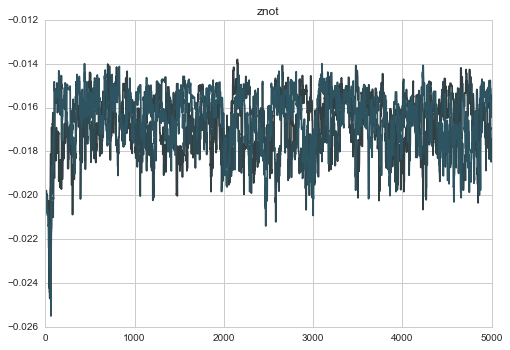

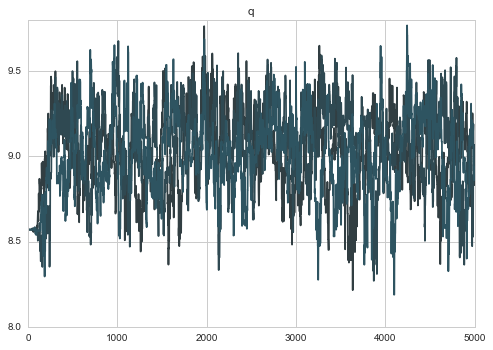

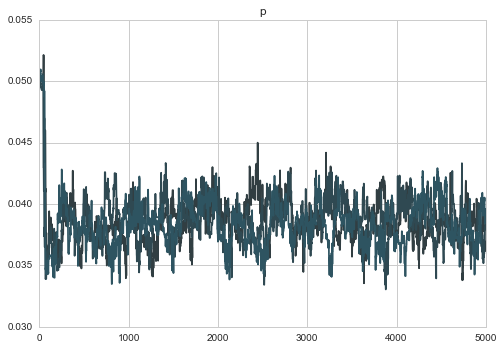

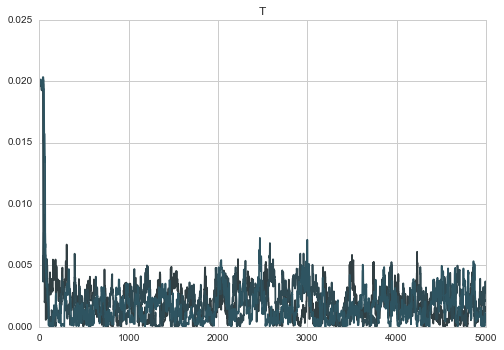

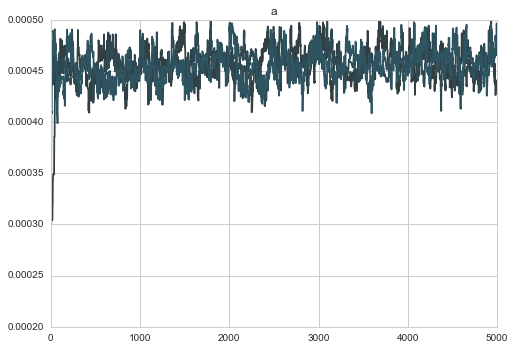

In [11]:
walks=(sampler.chain)
print(np.shape(walks))

for nn in range(0,ndim):
    pl.plot(walks[0,:,nn])
    pl.plot(walks[1,:,nn])
    pl.plot(walks[2,:,nn])
    titles = ['znot','q','p','T','a']
    pl.title(titles[nn])
    pl.show() #sigma = .001

In [12]:
samples = sampler.chain[:,2500:,:].reshape([-1, ndim])
print(np.shape(samples))

(650000, 5)


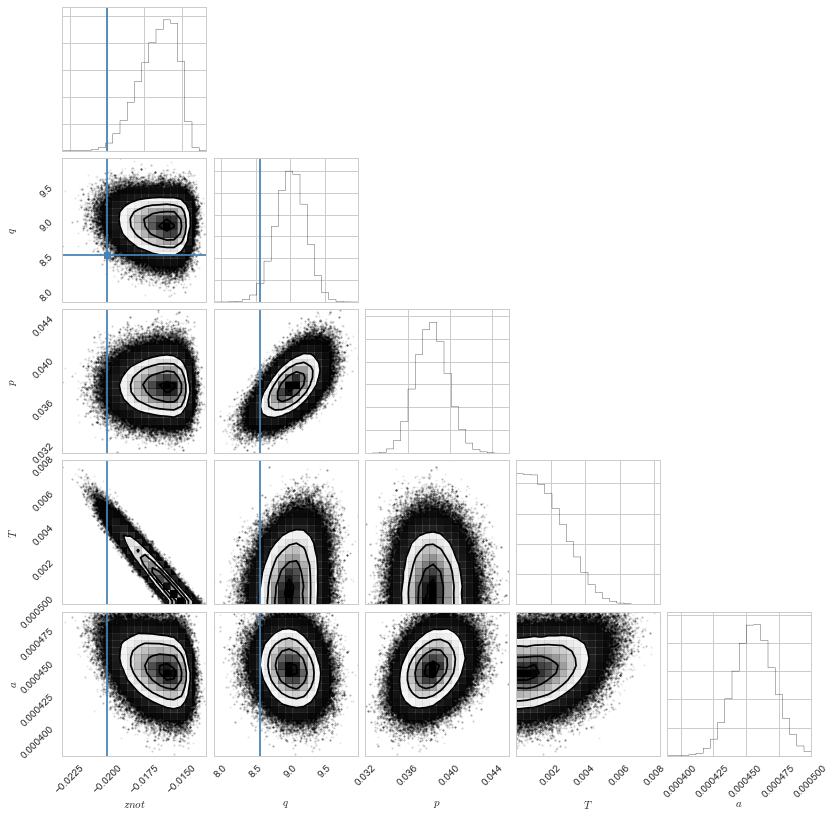

In [13]:
import corner
fig = corner.corner(samples, labels=["$znot$", "$q$", "$p$", "$T$", "$a$"], 
                    truths=[-.02, 8.57, .05, .02, .0002]) #znot: -.02
fig.savefig("MCMCattempt2.png")

In [14]:
#1. q = 7, p = .042, T = .001, a = .0002, z = -.01
#2. q = 7.5, p = .042, T = .001, a = .0002, z = -.012

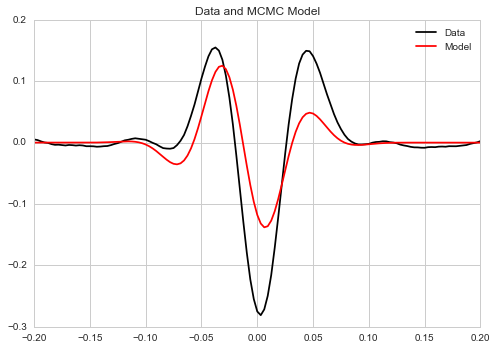

In [15]:
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1(-.01,9.4,0.036,0.001) #z,q,p,T

pl.plot(x,Modelf*.00024, label = 'Model', color = 'red')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

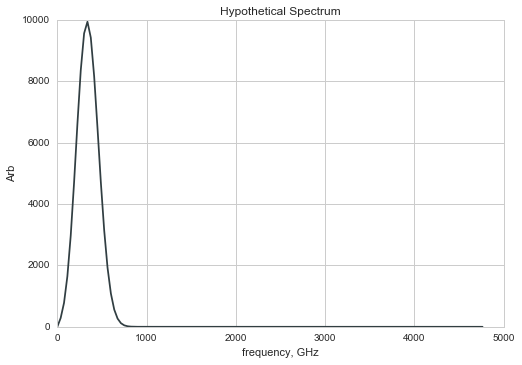

In [16]:
#for hazal!
S = np.fft.rfft(Modelf)
S = S[:-1]
u = np.abs(S)
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)

pl.title('Hypothetical Spectrum')
pl.plot()
pl.plot (300*Nu,np.abs(S)) 
pl.xlabel ("frequency, GHz")
pl.ylabel ('Arb')
pl.savefig('HypotheticalSpec')


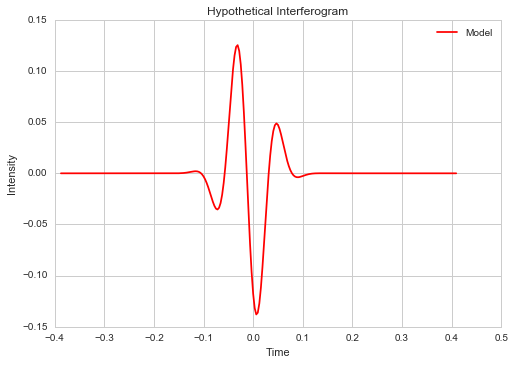

In [17]:
pl.plot(x,Modelf*.00024, label = 'Model', color = 'red')
pl.xlabel('Time')
pl.ylabel('Intensity')
pl.title('Hypothetical Interferogram')
pl.legend()
pl.savefig('HypotheticalInt')
pl.show()
